In [1]:
import pandas as pd
import numpy as np

def calculate_position_size(balance, risk_percentage):
    """Calculate position size based on balance and risk percentage."""
    return balance * (risk_percentage / 100)

def apply_stop_loss_take_profit(entry_price, current_price, stop_loss, take_profit):
    """Check stop loss / take profit conditions."""
    if current_price <= entry_price * (1 - stop_loss / 100):
        return 'stop_loss'
    elif current_price >= entry_price * (1 + take_profit / 100):
        return 'take_profit'
    return None

def backtest(df, y_pred, config):
    """
    Simplified backtest for notebooks.
    - 1 = Buy
    - -1 = Sell
    - 0 = Hold
    """

    df = df.copy()
    df['Predicted_Signal'] = y_pred

    initial_balance = config['backtesting']['initial_balance']
    balance = initial_balance
    position = 0
    entry_price = 0

    risk_percentage = config['risk_management']['risk_percentage']
    stop_loss = config['risk_management']['stop_loss']
    take_profit = config['risk_management']['take_profit']

    trades = []

    for i, row in df.iterrows():
        signal = row['Predicted_Signal']
        price = row['Close']

        if position == 0:  # No open trade
            if signal == 1:
                position_size = calculate_position_size(balance, risk_percentage)
                position = position_size / price
                balance -= position_size
                entry_price = price
                trades.append({
                    'type': 'BUY',
                    'price': price,
                    'balance': balance,
                    'index': i
                })

        elif position > 0:
            sl_tp_trigger = apply_stop_loss_take_profit(entry_price, price, stop_loss, take_profit)
            if signal == -1 or sl_tp_trigger in ['stop_loss', 'take_profit']:
                balance += position * price
                pnl = (price - entry_price) * position
                trades.append({
                    'type': 'SELL',
                    'price': price,
                    'pnl': pnl,
                    'balance': balance,
                    'index': i,
                    'reason': sl_tp_trigger or 'signal'
                })
                position = 0

    # Final balance
    final_balance = balance + (position * df.iloc[-1]['Close'] if position > 0 else 0)
    profit_pct = (final_balance - initial_balance) / initial_balance * 100

    results = {
        'initial_balance': initial_balance,
        'final_balance': final_balance,
        'profit_pct': profit_pct,
        'total_trades': len(trades),
        'trades': pd.DataFrame(trades)
    }

    return results

In [2]:
import os
import sys

# --- Fix path issues for Jupyter ---
project_root = r"C:\Users\arunm\Documents\Projects\Trading-App"
sys.path.append(os.path.join(project_root, "Utils"))

from preprocessing_helper import feature_engineering  # ✅ import directly

# --- Load your data (use raw string or forward slashes) ---
df = pd.read_csv(r"C:\Users\arunm\Documents\Projects\Trading-App\Data\Raw\Rawbtc_ohlcv_jan2023_to_sep2024.csv")

# --- Apply your feature engineering pipeline ---
df = feature_engineering(df)


In [6]:
# Call your backtest function
y_pred = df['label'].values

# Minimal config for backtest 
config = {
    'backtesting': {'initial_balance': 10000},
    'risk_management': {'risk_percentage': 10, 'stop_loss': 1.5, 'take_profit': 2.5}
}

results = backtest(df, y_pred, config)

# Print summary
print(f"Final Balance: {results['final_balance']:.2f}")
print(f"Profit %: {results['profit_pct']:.2f}%")
print(f"Total Trades: {results['total_trades']}")

# Optional: see the first few trades
results['trades'].head()


Final Balance: 9542.99
Profit %: -4.57%
Total Trades: 119716


,type,price,balance,index,pnl,reason
0,BUY,16528.53,9000.000000,53,NaN,NaN
1,SELL,16533.80,10000.318843,57,0.318843,signal
2,BUY,16531.35,9000.286958,65,NaN,NaN
3,SELL,16541.43,10000.928613,73,0.609770,signal
4,BUY,16535.19,9000.835751,99,NaN,NaN


In [8]:
# %% [markdown]
# # Label-based Backtest Visualization

# %% 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------
# Backtest function
# --------------------
def calculate_position_size(balance, risk_percentage):
    return balance * (risk_percentage / 100)

def apply_stop_loss_take_profit(entry_price, current_price, stop_loss, take_profit):
    if current_price <= entry_price * (1 - stop_loss / 100):
        return 'stop_loss'
    elif current_price >= entry_price * (1 + take_profit / 100):
        return 'take_profit'
    return None

def backtest(df, y_pred, config):
    df = df.copy()
    df['Predicted_Signal'] = y_pred

    initial_balance = config['backtesting']['initial_balance']
    balance = initial_balance
    position = 0
    entry_price = 0

    risk_percentage = config['risk_management']['risk_percentage']
    stop_loss = config['risk_management']['stop_loss']
    take_profit = config['risk_management']['take_profit']

    trades = []
    equity_curve = []

    for i, row in df.iterrows():
        signal = row['Predicted_Signal']
        price = row['Close']

        # Record equity
        equity_curve.append(balance + position * price)

        if position == 0:  # No open trade
            if signal == 1:
                position_size = calculate_position_size(balance, risk_percentage)
                position = position_size / price
                balance -= position_size
                entry_price = price
                trades.append({'type':'BUY','price':price,'index':i})

        elif position > 0:
            sl_tp_trigger = apply_stop_loss_take_profit(entry_price, price, stop_loss, take_profit)
            if signal == -1 or sl_tp_trigger in ['stop_loss', 'take_profit']:
                balance += position * price
                pnl = (price - entry_price) * position
                trades.append({'type':'SELL','price':price,'index':i,'pnl':pnl,'reason':sl_tp_trigger or 'signal'})
                position = 0

    # Final balance
    final_balance = balance + (position * df.iloc[-1]['Close'] if position > 0 else 0)
    profit_pct = (final_balance - initial_balance) / initial_balance * 100

    trades_df = pd.DataFrame(trades)
    trades_df['pnl'] = trades_df.get('pnl', np.nan)

    # Metrics
    wins = trades_df['pnl'].dropna() > 0
    win_rate = wins.sum() / len(wins) if len(wins) > 0 else np.nan
    avg_pnl = trades_df['pnl'].dropna().mean() if len(trades_df['pnl'].dropna())>0 else np.nan
    equity_curve = pd.Series(equity_curve, index=df.index)
    drawdown = equity_curve / equity_curve.cummax() - 1
    max_drawdown = drawdown.min()

    results = {
        'initial_balance': initial_balance,
        'final_balance': final_balance,
        'profit_pct': profit_pct,
        'total_trades': len(trades_df),
        'win_rate': win_rate,
        'avg_pnl': avg_pnl,
        'max_drawdown': max_drawdown,
        'equity_curve': equity_curve,
        'trades': trades_df
    }

    return results

In [13]:
def calculate_position_size(balance, risk_percentage):
    return balance * (risk_percentage / 100)

def apply_stop_loss_take_profit(entry_price, current_price, stop_loss, take_profit):
    if current_price <= entry_price * (1 - stop_loss / 100):
        return 'stop_loss'
    elif current_price >= entry_price * (1 + take_profit / 100):
        return 'take_profit'
    return None

def backtest_reduced_overtrading(df, config, threshold=0.4, min_hold=3):
    """
    Backtest using label_prob to reduce overtrading.
    - threshold: minimum label_prob to take a trade
    - min_hold: minimum number of minutes to hold before considering exit
    """
    df = df.copy()
    initial_balance = config['backtesting']['initial_balance']
    balance = initial_balance
    position = 0
    entry_price = 0
    hold_counter = 0

    risk_percentage = config['risk_management']['risk_percentage']
    stop_loss = config['risk_management']['stop_loss']
    take_profit = config['risk_management']['take_profit']

    trades = []

    for i, row in df.iterrows():
        signal_prob = row['label_prob']
        price = row['Close']
        direction = 0
        if signal_prob > threshold:
            direction = 1
        elif signal_prob < -threshold:
            direction = -1

        # Only take trades if no active position
        if position == 0:
            if direction == 1:
                position_size = calculate_position_size(balance, risk_percentage)
                position = position_size / price
                balance -= position_size
                entry_price = price
                hold_counter = 0
                trades.append({'type': 'BUY', 'price': price, 'balance': balance, 'index': i})
            # We skip shorting for simplicity; can add later

        elif position > 0:
            hold_counter += 1
            sl_tp_trigger = apply_stop_loss_take_profit(entry_price, price, stop_loss, take_profit)

            # Exit if SL/TP hit or signal reversal after minimum hold
            if (direction == -1 and hold_counter >= min_hold) or sl_tp_trigger in ['stop_loss', 'take_profit']:
                balance += position * price
                pnl = (price - entry_price) * position
                trades.append({
                    'type': 'SELL',
                    'price': price,
                    'pnl': pnl,
                    'balance': balance,
                    'index': i,
                    'reason': sl_tp_trigger or 'signal_reversal'
                })
                position = 0
                hold_counter = 0

    # Final balance
    final_balance = balance + (position * df.iloc[-1]['Close'] if position > 0 else 0)
    profit_pct = (final_balance - initial_balance) / initial_balance * 100

    results = {
        'initial_balance': initial_balance,
        'final_balance': final_balance,
        'profit_pct': profit_pct,
        'total_trades': len(trades),
        'trades': pd.DataFrame(trades)
    }

    return results

In [16]:
# %% 
# Use your label column as signals
y_pred = df['label'].values

# Minimal config
config = {
    'backtesting': {'initial_balance': 10000},
    'risk_management': {'risk_percentage': 10, 'stop_loss': 1.5, 'take_profit': 2.5}
}

# # Run backtest
# results = backtest_reduced_overtrading(df, y_pred, config)

# Example usage
config = {
    'backtesting': {'initial_balance': 10000},
    'risk_management': {'risk_percentage': 10, 'stop_loss': 1.5, 'take_profit': 2.5}
}

# Use the label column as predicted signal (or label_prob)
results = backtest_reduced_overtrading(df, config, threshold=0.4, min_hold=3)

# # Print metrics
# print(f"Initial Balance: {results['initial_balance']:.2f}")
# print(f"Final Balance: {results['final_balance']:.2f}")
# print(f"Profit %: {results['profit_pct']:.2f}%")
# print(f"Total Trades: {results['total_trades']}")
# print(f"Win Rate: {results['win_rate']:.2%}")
# print(f"Average PnL per trade: {results['avg_pnl']:.2f}")
# print(f"Max Drawdown: {results['max_drawdown']:.2%}")

print(f"Final Balance: {results['final_balance']:.2f}")
print(f"Profit %: {results['profit_pct']:.2f}%")
print(f"Total Trades: {results['total_trades']}")
results['trades'].head()

Final Balance: 9374.76
Profit %: -6.25%
Total Trades: 93686


,type,price,balance,index,pnl,reason
0,BUY,16536.07,9000.000000,67,NaN,NaN
1,SELL,16541.43,10000.324140,73,0.324140,signal_reversal
2,BUY,16535.19,9000.291726,99,NaN,NaN
3,SELL,16546.33,10000.997876,109,0.673737,signal_reversal
4,BUY,16540.52,9000.898089,112,NaN,NaN


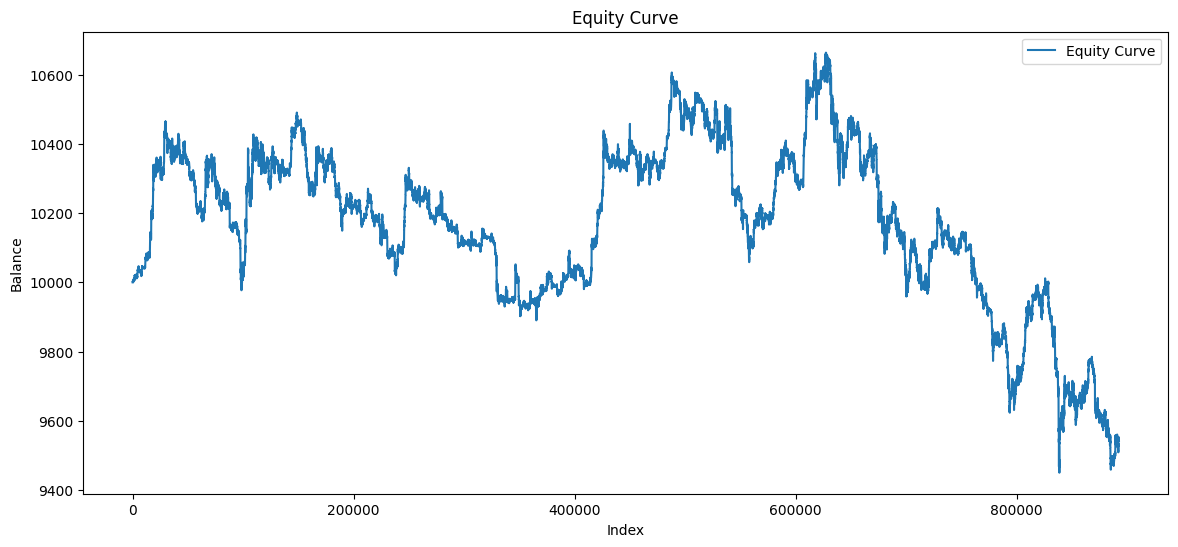

In [10]:
# %% 
# Plot equity curve
plt.figure(figsize=(14,6))
plt.plot(results['equity_curve'], label='Equity Curve')
plt.title("Equity Curve")
plt.xlabel("Index")
plt.ylabel("Balance")
plt.legend()
plt.show()

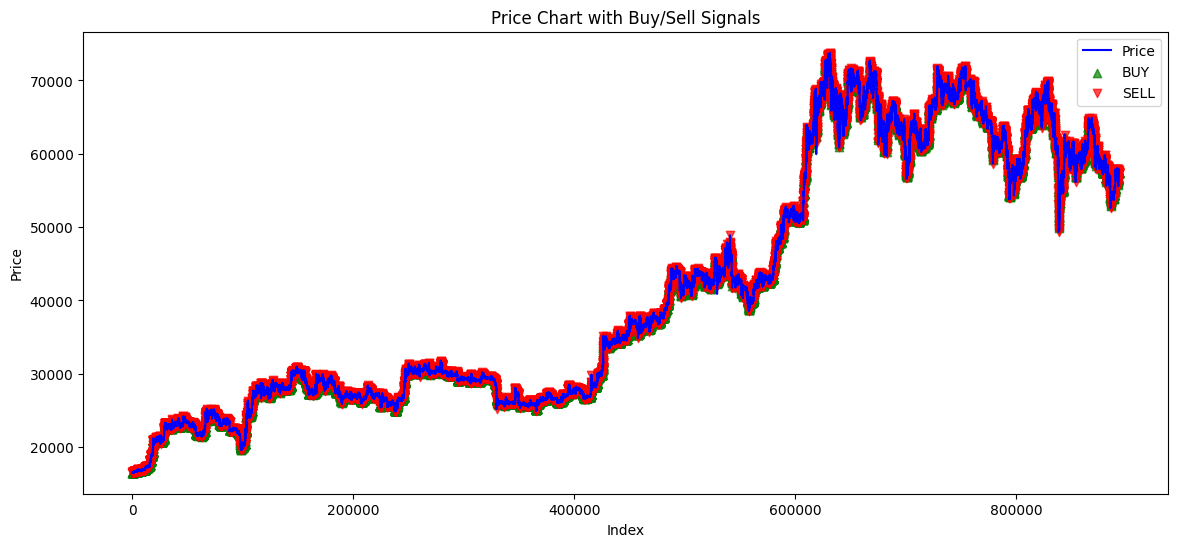

In [11]:
# %% 
# Plot price chart with buy/sell signals
plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Price', color='blue')
buy_signals = results['trades'][results['trades']['type']=='BUY']
sell_signals = results['trades'][results['trades']['type']=='SELL']
plt.scatter(buy_signals['index'], buy_signals['price'], marker='^', color='green', label='BUY', alpha=0.7)
plt.scatter(sell_signals['index'], sell_signals['price'], marker='v', color='red', label='SELL', alpha=0.7)
plt.title("Price Chart with Buy/Sell Signals")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.show()

In [17]:
import pandas as pd
import numpy as np
import talib
from sklearn.preprocessing import MinMaxScaler
import pandas_ta as ta

# %% [markdown]
# # Label-based Backtest Visualization

import matplotlib.pyplot as plt

# --------------------
# Backtest function
# --------------------
def calculate_position_size(balance, risk_percentage):
    return balance * (risk_percentage / 100)

def apply_stop_loss_take_profit(entry_price, current_price, stop_loss, take_profit):
    if current_price <= entry_price * (1 - stop_loss / 100):
        return 'stop_loss'
    elif current_price >= entry_price * (1 + take_profit / 100):
        return 'take_profit'
    return None

def backtest(df, y_pred, config):
    df = df.copy()
    df['Predicted_Signal'] = y_pred

    initial_balance = config['backtesting']['initial_balance']
    balance = initial_balance
    position = 0
    entry_price = 0

    risk_percentage = config['risk_management']['risk_percentage']
    stop_loss = config['risk_management']['stop_loss']
    take_profit = config['risk_management']['take_profit']

    trades = []
    equity_curve = []

    for i, row in df.iterrows():
        signal = row['Predicted_Signal']
        price = row['Close']

        # Record equity
        equity_curve.append(balance + position * price)

        if position == 0:  # No open trade
            if signal == 1:
                position_size = calculate_position_size(balance, risk_percentage)
                position = position_size / price
                balance -= position_size
                entry_price = price
                trades.append({'type':'BUY','price':price,'index':i})

        elif position > 0:
            sl_tp_trigger = apply_stop_loss_take_profit(entry_price, price, stop_loss, take_profit)
            if signal == -1 or sl_tp_trigger in ['stop_loss', 'take_profit']:
                balance += position * price
                pnl = (price - entry_price) * position
                trades.append({'type':'SELL','price':price,'index':i,'pnl':pnl,'reason':sl_tp_trigger or 'signal'})
                position = 0

    # Final balance
    final_balance = balance + (position * df.iloc[-1]['Close'] if position > 0 else 0)
    profit_pct = (final_balance - initial_balance) / initial_balance * 100

    trades_df = pd.DataFrame(trades)
    trades_df['pnl'] = trades_df.get('pnl', np.nan)

    # Metrics
    wins = trades_df['pnl'].dropna() > 0
    win_rate = wins.sum() / len(wins) if len(wins) > 0 else np.nan
    avg_pnl = trades_df['pnl'].dropna().mean() if len(trades_df['pnl'].dropna())>0 else np.nan
    equity_curve = pd.Series(equity_curve, index=df.index)
    drawdown = equity_curve / equity_curve.cummax() - 1
    max_drawdown = drawdown.min()

    results = {
        'initial_balance': initial_balance,
        'final_balance': final_balance,
        'profit_pct': profit_pct,
        'total_trades': len(trades_df),
        'win_rate': win_rate,
        'avg_pnl': avg_pnl,
        'max_drawdown': max_drawdown,
        'equity_curve': equity_curve,
        'trades': trades_df
    }

    return results
    
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """Clean the data by replacing infinities with NaN and dropping rows with NaN."""
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    return df


def generate_labels(df: pd.DataFrame, horizon: int = 5, atr_mult: float = 1.5) -> pd.DataFrame:
    """
    Generate hybrid probabilistic + consensus-based labels for Buy/Hold/Sell classification.

    Args:
        df (pd.DataFrame): Feature-engineered DataFrame (from feature_engineering()).
        horizon (int): How many minutes ahead to look for future price change.
        atr_mult (float): Volatility multiplier for dynamic labeling threshold.

    Returns:
        df (pd.DataFrame): Original DataFrame with added 'label' and 'label_prob' columns.
    """
    df = df.copy()

    # ---------------------------
    # 1. Compute Future Return
    # ---------------------------
    df['future_close'] = df['Close'].shift(-horizon)
    df['future_ret'] = (df['future_close'] - df['Close']) / df['Close']

    # ---------------------------
    # 2. Multi-Indicator Consensus
    # ---------------------------
    # Weighted consensus of major directional indicators
    consensus = (
            0.25 * np.sign(df['ema_diff_9_21']) +  # short-term trend
            0.20 * np.sign(df['macd_hist']) +  # momentum direction
            0.15 * np.sign(df['rsi_norm']) +  # overbought/oversold
            0.15 * df['supertrend_dir'] +  # trend direction
            0.10 * np.sign(df['cci_norm']) +  # momentum deviation
            0.10 * np.sign(df['obv_slope']) +  # volume confirmation
            0.05 * np.sign(df['mfi_norm'])  # money flow
    )
    df['consensus_score'] = consensus.clip(-1, 1)

    # ---------------------------
    # 3. Probabilistic Label Scaling
    # ---------------------------
    # Dynamic volatility-adjusted threshold
    atr_threshold = df['atr_pct'].rolling(20).mean() * atr_mult

    # Normalize probability between 0 and 1
    df['label_prob'] = np.tanh(df['future_ret'] / (atr_threshold + 1e-6)) * df['consensus_score']

    # ---------------------------
    # 4. Discrete Labels: Buy / Hold / Sell
    # ---------------------------
    buy_cond = df['label_prob'] > 0.3
    sell_cond = df['label_prob'] < -0.3

    df['label'] = 0  # hold by default
    df.loc[buy_cond, 'label'] = 1
    df.loc[sell_cond, 'label'] = -1

    # Clean up
    df.dropna(subset=['label_prob'], inplace=True)
    return df


def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """
    df: pandas DataFrame with columns ['open','high','low','close','volume']
    Returns: df with features for Core 12 indicators ready for ML/backtesting
    """

    df = df.copy()

    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
    df['High'] = pd.to_numeric(df['High'], errors='coerce')
    df['Low'] = pd.to_numeric(df['Low'], errors='coerce')
    df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

    # --------------------
    # TREND INDICATORS
    # --------------------
    # EMA
    df['ema9'] = ta.ema(df['Close'], length=9)
    df['ema21'] = ta.ema(df['Close'], length=21)
    df['ema50'] = ta.ema(df['Close'], length=50)
    df['ema_diff_21_50'] = df['ema21'] - df['ema50']          # feature: trend slope
    df['ema_diff_9_21'] = df['ema9'] - df['ema21']

    # HMA
    df['hma14'] = ta.hma(df['Close'], length=14)
    df['hma_slope'] = df['hma14'].diff()

    # SuperTrend
    st = ta.supertrend(df['High'], df['Low'], df['Close'], length=14, multiplier=3)
    df['supertrend'] = st[st.columns[0]]
    df['supertrend_dir'] = st[st.columns[1]]
    df['supertrend_dist'] = df['Close'] - df['supertrend']

    # --------------------
    # MOMENTUM / OSCILLATORS
    # --------------------
    # RSI
    df['rsi14'] = ta.rsi(df['Close'], length=14)
    df['rsi_norm'] = (df['rsi14'] - 50)/50                      # normalize around 0

    # Stochastic RSI
    stoch_rsi = ta.stochrsi(df['Close'], length=14, rsi_length=14, k=3, d=3)
    df['stoch_rsi_k'] = stoch_rsi['STOCHRSIk_14_14_3_3']
    df['stoch_rsi_d'] = stoch_rsi['STOCHRSId_14_14_3_3']
    df['stoch_rsi_signal'] = df['stoch_rsi_k'].apply(lambda x: 1 if x < 0.2 else -1 if x > 0.8 else 0)

    # MACD
    macd = ta.macd(df['Close'], fast=12, slow=26, signal=9)
    df['macd'] = macd['MACD_12_26_9']
    df['macd_signal'] = macd['MACDs_12_26_9']
    df['macd_hist'] = df['macd'] - df['macd_signal']
    df['macd_cross'] = df['macd_hist'].apply(lambda x: 1 if x>0 else -1)

    # CCI
    df['cci20'] = ta.cci(df['High'], df['Low'], df['Close'], length=20)
    df['cci_norm'] = df['cci20']/100

    # --------------------
    # VOLATILITY / RANGE
    # --------------------
    # Bollinger Bands
    bb = ta.bbands(df['Close'], length=20, std=2)
    df['bb_upper'] = bb['BBU_20_2.0']
    df['bb_lower'] = bb['BBL_20_2.0']
    df['bb_pos'] = (df['Close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])

    # ATR
    df['atr14'] = ta.atr(df['High'], df['Low'], df['Close'], length=14)
    df['atr_pct'] = df['atr14']/df['Close']

    # --------------------
    # VOLUME / FLOW
    # --------------------
    # OBV
    df['obv'] = ta.obv(df['Close'], df['Volume'])
    df['obv_slope'] = df['obv'].diff()

    # MFI
    df['mfi14'] = ta.mfi(df['High'], df['Low'], df['Close'], df['Volume'], length=14)
    df['mfi_norm'] = (df['mfi14'] - 50)/50

    # --------------------
    # MARKET REGIME FILTER
    # --------------------
    df['adx14'] = ta.adx(df['High'], df['Low'], df['Close'], length=14)['ADX_14']
    df['adx_scaled'] = df['adx14']/100

    # --------------------
    # Label
    # --------------------

    df = generate_labels(df, horizon=3, atr_mult=1.5)

    # --------------------
    # CLEAN UP
    # --------------------
    # Drop raw columns if you only want engineered features
    feature_cols = ["Open", "Close", 'ema_diff_21_50', 'ema_diff_9_21', 'hma_slope', 'supertrend_dir', 'supertrend_dist',
                    'rsi_norm', 'stoch_rsi_signal', 'stoch_rsi_k', 'stoch_rsi_d',
                    'macd_hist', 'macd_cross', 'macd_signal', 'cci_norm',
                    'bb_pos', 'atr_pct', 'obv_slope', 'mfi_norm', 'adx_scaled',
                    'consensus_score', 'label_prob', 'label']

    df = clean_data(df)
    return df[feature_cols].dropna()

import os
import sys

# --- Fix path issues for Jupyter ---
project_root = r"C:\Users\arunm\Documents\Projects\Trading-App"
sys.path.append(os.path.join(project_root, "Utils"))

from preprocessing_helper import feature_engineering  # ✅ import directly

# # --- Load your data (use raw string or forward slashes) ---
# df = pd.read_csv(r"C:\Users\arunm\Documents\Projects\Trading-App\Data\Raw\Rawbtc_ohlcv_jan2023_to_sep2024.csv")

# # --- Apply your feature engineering pipeline ---
# df = feature_engineering(df)


# # %% 
# # Use your label column as signals
# y_pred = df['label'].values

# # Minimal config
# config = {
#     'backtesting': {'initial_balance': 10000},
#     'risk_management': {'risk_percentage': 10, 'stop_loss': 1.5, 'take_profit': 2.5}
# }

# # # Run backtest
# # results = backtest_reduced_overtrading(df, y_pred, config)

# # Example usage
# config = {
#     'backtesting': {'initial_balance': 10000},
#     'risk_management': {'risk_percentage': 10, 'stop_loss': 1.5, 'take_profit': 2.5}
# }

# # Use the label column as predicted signal (or label_prob)
# results = backtest_reduced_overtrading(df, config, threshold=0.4, min_hold=3)

# # # Print metrics
# # print(f"Initial Balance: {results['initial_balance']:.2f}")
# # print(f"Final Balance: {results['final_balance']:.2f}")
# # print(f"Profit %: {results['profit_pct']:.2f}%")
# # print(f"Total Trades: {results['total_trades']}")
# # print(f"Win Rate: {results['win_rate']:.2%}")
# # print(f"Average PnL per trade: {results['avg_pnl']:.2f}")
# # print(f"Max Drawdown: {results['max_drawdown']:.2%}")

# print(f"Final Balance: {results['final_balance']:.2f}")
# print(f"Profit %: {results['profit_pct']:.2f}%")
# print(f"Total Trades: {results['total_trades']}")
# results['trades'].head()
# --- Load and feature-engineer the data ---
df = pd.read_csv(r"C:\Users\arunm\Documents\Projects\Trading-App\Data\Raw\Rawbtc_ohlcv_jan2023_to_sep2024.csv")
df = feature_engineering(df)

# --- Minimal backtest config ---
config = {
    'backtesting': {'initial_balance': 10000},
    'risk_management': {'risk_percentage': 10, 'stop_loss': 1.5, 'take_profit': 2.5}
}

# --- Loop over multiple label variants ---
label_configs = [
    {'horizon': 3, 'atr_mult': 1.2, 'threshold': 0.2},
    {'horizon': 3, 'atr_mult': 1.5, 'threshold': 0.3},
    {'horizon': 5, 'atr_mult': 1.5, 'threshold': 0.3},
    {'horizon': 5, 'atr_mult': 2.0, 'threshold': 0.4},
    {'horizon': 10, 'atr_mult': 1.5, 'threshold': 0.3},
    {'horizon': 10, 'atr_mult': 2.0, 'threshold': 0.4},
]

for idx, cfg in enumerate(label_configs, 1):
    # Recompute label column
    df_labels = generate_labels(df, horizon=cfg['horizon'], atr_mult=cfg['atr_mult'])
    
    # Run backtest
    results = backtest_reduced_overtrading(df_labels, config, threshold=cfg['threshold'], min_hold=3)
    
    print(f"\n--- Backtest #{idx} Results ---")
    print(f"Horizon: {cfg['horizon']}, ATR Mult: {cfg['atr_mult']}, Threshold: {cfg['threshold']}")
    print(f"Final Balance: {results['final_balance']:.2f}")
    print(f"Profit %: {results['profit_pct']:.2f}%")
    print(f"Total Trades: {results['total_trades']}")
    print(f"Win Rate: {results['win_rate']:.2%}")
    print(f"Average PnL per trade: {results['avg_pnl']:.2f}")
    print(f"Max Drawdown: {results['max_drawdown']:.2%}")


In [24]:
# --------------------
# Imports
# --------------------
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt

# --------------------
# Helper functions
# --------------------
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    return df

def calculate_position_size(balance, risk_percentage):
    return balance * (risk_percentage / 100)

def apply_stop_loss_take_profit(entry_price, current_price, stop_loss, take_profit):
    if current_price <= entry_price * (1 - stop_loss / 100):
        return 'stop_loss'
    elif current_price >= entry_price * (1 + take_profit / 100):
        return 'take_profit'
    return None

# --------------------
# Standard Backtest
# --------------------
def backtest(df, y_pred, config):
    df = df.copy()
    df['Predicted_Signal'] = y_pred

    initial_balance = config['backtesting']['initial_balance']
    balance = initial_balance
    position = 0
    entry_price = 0

    risk_percentage = config['risk_management']['risk_percentage']
    stop_loss = config['risk_management']['stop_loss']
    take_profit = config['risk_management']['take_profit']

    trades = []
    equity_curve = []

    for i, row in df.iterrows():
        signal = row['Predicted_Signal']
        price = row['Close']

        equity_curve.append(balance + position * price)

        if position == 0 and signal == 1:
            position_size = calculate_position_size(balance, risk_percentage)
            position = position_size / price
            balance -= position_size
            entry_price = price
            trades.append({'type':'BUY','price':price,'index':i})

        elif position > 0:
            sl_tp_trigger = apply_stop_loss_take_profit(entry_price, price, stop_loss, take_profit)
            if signal == -1 or sl_tp_trigger in ['stop_loss', 'take_profit']:
                balance += position * price
                pnl = (price - entry_price) * position
                trades.append({'type':'SELL','price':price,'index':i,'pnl':pnl,'reason':sl_tp_trigger or 'signal'})
                position = 0

    final_balance = balance + (position * df.iloc[-1]['Close'] if position > 0 else 0)
    profit_pct = (final_balance - initial_balance) / initial_balance * 100

    trades_df = pd.DataFrame(trades)
    trades_df['pnl'] = trades_df.get('pnl', np.nan)

    # Metrics
    wins = trades_df['pnl'].dropna() > 0
    win_rate = wins.sum() / len(wins) if len(wins) > 0 else np.nan
    avg_pnl = trades_df['pnl'].dropna().mean() if len(trades_df['pnl'].dropna())>0 else np.nan
    equity_curve = pd.Series(equity_curve, index=df.index)
    max_drawdown = (equity_curve / equity_curve.cummax() - 1).min()

    results = {
        'initial_balance': initial_balance,
        'final_balance': final_balance,
        'profit_pct': profit_pct,
        'total_trades': len(trades_df),
        'win_rate': win_rate,
        'avg_pnl': avg_pnl,
        'max_drawdown': max_drawdown,
        'equity_curve': equity_curve,
        'trades': trades_df
    }
    return results

# --------------------
# Feature Engineering + Label Generation
# --------------------
def generate_labels(df: pd.DataFrame, horizon=5, atr_mult=1.5, threshold = 0.2) -> pd.DataFrame:
    df = df.copy()
    df['future_close'] = df['Close'].shift(-horizon)
    df['future_ret'] = (df['future_close'] - df['Close']) / df['Close']

    # Consensus of indicators
    consensus = (
        0.25 * np.sign(df.get('ema_diff_9_21', 0)) +
        0.20 * np.sign(df.get('macd_hist', 0)) +
        0.15 * np.sign(df.get('rsi_norm', 0)) +
        0.15 * df.get('supertrend_dir', 0) +
        0.10 * np.sign(df.get('cci_norm', 0)) +
        0.10 * np.sign(df.get('obv_slope', 0)) +
        0.05 * np.sign(df.get('mfi_norm', 0))
    )
    df['consensus_score'] = consensus.clip(-1,1)

    atr_threshold = df['atr_pct'].rolling(20).mean() * atr_mult
    df['label_prob'] = np.tanh(df['future_ret'] / (atr_threshold + 1e-6)) * df['consensus_score']

    buy_cond = df['label_prob'] > threshold
    sell_cond = df['label_prob'] < -threshold
    df['label'] = 0
    df.loc[buy_cond, 'label'] = 1
    df.loc[sell_cond, 'label'] = -1

    df.dropna(subset=['label_prob'], inplace=True)
    return df

def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
    df['High'] = pd.to_numeric(df['High'], errors='coerce')
    df['Low'] = pd.to_numeric(df['Low'], errors='coerce')
    df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

    # EMA
    df['ema9'] = ta.ema(df['Close'], length=9)
    df['ema21'] = ta.ema(df['Close'], length=21)
    df['ema50'] = ta.ema(df['Close'], length=50)
    df['ema_diff_21_50'] = df['ema21'] - df['ema50']
    df['ema_diff_9_21'] = df['ema9'] - df['ema21']

    # SuperTrend
    st = ta.supertrend(df['High'], df['Low'], df['Close'], length=14, multiplier=3)
    df['supertrend'] = st[st.columns[0]]
    df['supertrend_dir'] = st[st.columns[1]]
    df['supertrend_dist'] = df['Close'] - df['supertrend']

    # Momentum / Oscillators
    df['rsi14'] = ta.rsi(df['Close'], length=14)
    df['rsi_norm'] = (df['rsi14'] - 50)/50
    macd = ta.macd(df['Close'], fast=12, slow=26, signal=9)
    df['macd'] = macd['MACD_12_26_9']
    df['macd_signal'] = macd['MACDs_12_26_9']
    df['macd_hist'] = df['macd'] - df['macd_signal']
    df['macd_cross'] = df['macd_hist'].apply(lambda x: 1 if x>0 else -1)

    df['cci20'] = ta.cci(df['High'], df['Low'], df['Close'], length=20)
    df['cci_norm'] = df['cci20']/100

    # ATR
    df['atr14'] = ta.atr(df['High'], df['Low'], df['Close'], length=14)
    df['atr_pct'] = df['atr14']/df['Close']

    # OBV & MFI
    df['obv'] = ta.obv(df['Close'], df['Volume'])
    df['obv_slope'] = df['obv'].diff()
    df['mfi14'] = ta.mfi(df['High'], df['Low'], df['Close'], df['Volume'], length=14)
    df['mfi_norm'] = (df['mfi14'] - 50)/50

    df = clean_data(df)
    return df

# --------------------
# Reduced Overtrading Wrapper
# --------------------
def backtest_reduced_overtrading(df, config, threshold=0.3, min_hold=3):
    # Use label column
    y_pred = df['label'].copy()

    # Simple threshold filter
    y_pred[y_pred.abs() < threshold] = 0

    results = backtest(df, y_pred, config)

    # Compute extra metrics
    trades = results['trades']
    if 'pnl' in trades.columns:
        wins = trades['pnl'].dropna() > 0
        results['win_rate'] = wins.sum() / len(wins) if len(wins) > 0 else np.nan
        results['avg_pnl'] = trades['pnl'].dropna().mean() if len(trades['pnl'].dropna())>0 else np.nan
    else:
        results['win_rate'] = np.nan
        results['avg_pnl'] = np.nan

    equity_curve = results.get('equity_curve', pd.Series(np.nan, index=df.index))
    results['max_drawdown'] = (equity_curve / equity_curve.cummax() - 1).min() if len(equity_curve) > 0 else np.nan

    return results

# --------------------
# Load Data
# --------------------
df = pd.read_csv(r"C:\Users\arunm\Documents\Projects\Trading-App\Data\Raw\Rawbtc_ohlcv_jan2023_to_sep2024.csv")
df = feature_engineering(df)

# --------------------
# Backtest Config
# --------------------
config = {
    'backtesting': {'initial_balance': 10000},
    'risk_management': {'risk_percentage': 10, 'stop_loss': 1.5, 'take_profit': 2.5}
}

# --------------------
# Multiple Label Variants
# --------------------
label_configs = [
    {'horizon': 3, 'atr_mult': 1.2, 'threshold': 0.2},
    {'horizon': 3, 'atr_mult': 1.5, 'threshold': 0.3},
    {'horizon': 5, 'atr_mult': 1.5, 'threshold': 0.3},
    {'horizon': 5, 'atr_mult': 2.0, 'threshold': 0.4},
    {'horizon': 10, 'atr_mult': 1.5, 'threshold': 0.3},
    {'horizon': 10, 'atr_mult': 2.0, 'threshold': 0.4},
]

# --------------------
# Run Backtests
# --------------------
for idx, cfg in enumerate(label_configs, 1):
    df_labels = generate_labels(df, horizon=cfg['horizon'], atr_mult=cfg['atr_mult'], threshold = cfg['threshold'])
    results = backtest_reduced_overtrading(df_labels, config, threshold=cfg['threshold'], min_hold=3)

    print(f"\n--- Backtest #{idx} Results ---")
    print(f"Horizon: {cfg['horizon']}, ATR Mult: {cfg['atr_mult']}, Threshold: {cfg['threshold']}")
    print(f"Final Balance: {results['final_balance']:.2f}")
    print(f"Profit %: {results['profit_pct']:.2f}%")
    print(f"Total Trades: {results['total_trades']}")
    print(f"Win Rate: {results['win_rate']:.2%}")
    print(f"Average PnL per trade: {results['avg_pnl']:.2f}")
    print(f"Max Drawdown: {results['max_drawdown']:.2%}")



--- Backtest #1 Results ---
Horizon: 3, ATR Mult: 1.2, Threshold: 0.2
Final Balance: 10154.66
Profit %: 1.55%
Total Trades: 158074
Win Rate: 49.85%
Average PnL per trade: 0.00
Max Drawdown: -10.23%

--- Backtest #2 Results ---
Horizon: 3, ATR Mult: 1.5, Threshold: 0.3
Final Balance: 9542.43
Profit %: -4.58%
Total Trades: 119714
Win Rate: 49.49%
Average PnL per trade: -0.01
Max Drawdown: -11.37%

--- Backtest #3 Results ---
Horizon: 5, ATR Mult: 1.5, Threshold: 0.3
Final Balance: 10432.49
Profit %: 4.32%
Total Trades: 99191
Win Rate: 49.74%
Average PnL per trade: 0.01
Max Drawdown: -8.46%

--- Backtest #4 Results ---
Horizon: 5, ATR Mult: 2.0, Threshold: 0.4
Final Balance: 9845.87
Profit %: -1.54%
Total Trades: 69611
Win Rate: 49.51%
Average PnL per trade: -0.00
Max Drawdown: -11.19%

--- Backtest #5 Results ---
Horizon: 10, ATR Mult: 1.5, Threshold: 0.3
Final Balance: 10681.53
Profit %: 6.82%
Total Trades: 79424
Win Rate: 49.85%
Average PnL per trade: 0.02
Max Drawdown: -6.46%

--- Ba

In [27]:
label_configs_new = [
    {'horizon': 2, 'atr_mult': 1.0, 'threshold': 0.2},   # faster signals, lower volatility
    {'horizon': 2, 'atr_mult': 1.5, 'threshold': 0.25},  # faster signals, mid volatility
    {'horizon': 3, 'atr_mult': 1.8, 'threshold': 0.35},  # short-term, higher threshold
    {'horizon': 4, 'atr_mult': 1.2, 'threshold': 0.25},  # mid-short horizon
    {'horizon': 4, 'atr_mult': 1.5, 'threshold': 0.3},   # mid-short horizon, base threshold
    {'horizon': 6, 'atr_mult': 1.5, 'threshold': 0.35},  # medium horizon
    {'horizon': 6, 'atr_mult': 2.0, 'threshold': 0.4},   # medium horizon, higher threshold
    {'horizon': 8, 'atr_mult': 1.5, 'threshold': 0.3},   # longer horizon
    {'horizon': 8, 'atr_mult': 2.0, 'threshold': 0.4},   # longer horizon, higher volatility
    {'horizon': 12, 'atr_mult': 2.0, 'threshold': 0.45}, # long-term conservative threshold
]

# --------------------
# Run Backtests
# --------------------
for idx, cfg in enumerate(label_configs_new, 1):
    df_labels = generate_labels(df, horizon=cfg['horizon'], atr_mult=cfg['atr_mult'], threshold = cfg['threshold'])
    results = backtest_reduced_overtrading(df_labels, config, threshold=cfg['threshold'], min_hold=3)

    print(f"\n--- Backtest #{idx} Results ---")
    print(f"Horizon: {cfg['horizon']}, ATR Mult: {cfg['atr_mult']}, Threshold: {cfg['threshold']}")
    print(f"Final Balance: {results['final_balance']:.2f}")
    print(f"Profit %: {results['profit_pct']:.2f}%")
    print(f"Total Trades: {results['total_trades']}")
    print(f"Win Rate: {results['win_rate']:.2%}")
    print(f"Average PnL per trade: {results['avg_pnl']:.2f}")
    print(f"Max Drawdown: {results['max_drawdown']:.2%}")


--- Backtest #1 Results ---
Horizon: 2, ATR Mult: 1.0, Threshold: 0.2
Final Balance: 9981.81
Profit %: -0.18%
Total Trades: 197150
Win Rate: 49.92%
Average PnL per trade: -0.00
Max Drawdown: -11.75%

--- Backtest #2 Results ---
Horizon: 2, ATR Mult: 1.5, Threshold: 0.25
Final Balance: 9270.28
Profit %: -7.30%
Total Trades: 153586
Win Rate: 49.48%
Average PnL per trade: -0.01
Max Drawdown: -13.32%

--- Backtest #3 Results ---
Horizon: 3, ATR Mult: 1.8, Threshold: 0.35
Final Balance: 9352.71
Profit %: -6.47%
Total Trades: 96956
Win Rate: 49.38%
Average PnL per trade: -0.01
Max Drawdown: -12.65%

--- Backtest #4 Results ---
Horizon: 4, ATR Mult: 1.2, Threshold: 0.25
Final Balance: 10332.93
Profit %: 3.33%
Total Trades: 129754
Win Rate: 49.62%
Average PnL per trade: 0.01
Max Drawdown: -9.09%

--- Backtest #5 Results ---
Horizon: 4, ATR Mult: 1.5, Threshold: 0.3
Final Balance: 10269.59
Profit %: 2.70%
Total Trades: 107628
Win Rate: 49.62%
Average PnL per trade: 0.01
Max Drawdown: -9.02%

-

In [28]:
label_configs = [
    {'horizon': 10, 'atr_mult': 2.0, 'threshold': 0.4},
    {'horizon': 12, 'atr_mult': 2.0, 'threshold': 0.4},
    {'horizon': 15, 'atr_mult': 2.0, 'threshold': 0.4},
    {'horizon': 17, 'atr_mult': 2.0, 'threshold': 0.4},
    {'horizon': 20, 'atr_mult': 2.0, 'threshold': 0.4},
    {'horizon': 10, 'atr_mult': 2.2, 'threshold': 0.4},
    {'horizon': 10, 'atr_mult': 2.5, 'threshold': 0.4},
    {'horizon': 10, 'atr_mult': 2.8, 'threshold': 0.4},
    {'horizon': 10, 'atr_mult': 2.0, 'threshold': 0.4},
    {'horizon': 10, 'atr_mult': 2.0, 'threshold': 0.45},
    {'horizon': 10, 'atr_mult': 2.0, 'threshold': 0.5}
]

# --------------------
# Run Backtests
# --------------------
for idx, cfg in enumerate(label_configs, 1):
    df_labels = generate_labels(df, horizon=cfg['horizon'], atr_mult=cfg['atr_mult'], threshold = cfg['threshold'])
    results = backtest_reduced_overtrading(df_labels, config, threshold=cfg['threshold'], min_hold=3)

    print(f"\n--- Backtest #{idx} Results ---")
    print(f"Horizon: {cfg['horizon']}, ATR Mult: {cfg['atr_mult']}, Threshold: {cfg['threshold']}")
    print(f"Final Balance: {results['final_balance']:.2f}")
    print(f"Profit %: {results['profit_pct']:.2f}%")
    print(f"Total Trades: {results['total_trades']}")
    print(f"Win Rate: {results['win_rate']:.2%}")
    print(f"Average PnL per trade: {results['avg_pnl']:.2f}")
    print(f"Max Drawdown: {results['max_drawdown']:.2%}")


--- Backtest #1 Results ---
Horizon: 10, ATR Mult: 2.0, Threshold: 0.4
Final Balance: 10690.46
Profit %: 6.90%
Total Trades: 56989
Win Rate: 49.68%
Average PnL per trade: 0.02
Max Drawdown: -7.18%

--- Backtest #2 Results ---
Horizon: 12, ATR Mult: 2.0, Threshold: 0.4
Final Balance: 10789.94
Profit %: 7.90%
Total Trades: 54799
Win Rate: 49.76%
Average PnL per trade: 0.03
Max Drawdown: -5.55%

--- Backtest #3 Results ---
Horizon: 15, ATR Mult: 2.0, Threshold: 0.4
Final Balance: 10849.41
Profit %: 8.49%
Total Trades: 52165
Win Rate: 49.93%
Average PnL per trade: 0.03
Max Drawdown: -6.11%

--- Backtest #4 Results ---
Horizon: 17, ATR Mult: 2.0, Threshold: 0.4
Final Balance: 10975.39
Profit %: 9.75%
Total Trades: 51630
Win Rate: 50.18%
Average PnL per trade: 0.04
Max Drawdown: -5.80%

--- Backtest #5 Results ---
Horizon: 20, ATR Mult: 2.0, Threshold: 0.4
Final Balance: 10836.75
Profit %: 8.37%
Total Trades: 50190
Win Rate: 49.85%
Average PnL per trade: 0.03
Max Drawdown: -5.23%

--- Backt

In [34]:
label_configs = [
    # {'horizon': 5, 'atr_mult': 1.5, 'threshold': 0.25},
    # {'horizon': 6, 'atr_mult': 1.5, 'threshold': 0.3},
    # {'horizon': 8, 'atr_mult': 1.5, 'threshold': 0.3},
    # {'horizon': 10, 'atr_mult': 1.5, 'threshold': 0.35},
    # {'horizon': 12, 'atr_mult': 1.5, 'threshold': 0.4},
    {'horizon': 20, 'atr_mult': 1.5, 'threshold': 0.35},
    {'horizon': 20, 'atr_mult': 1.5, 'threshold': 0.4},
    {'horizon': 25, 'atr_mult': 1.5, 'threshold': 0.4},
    {'horizon': 30, 'atr_mult': 1.5, 'threshold': 0.4}
]

# --------------------
# Run Backtests
# --------------------
for idx, cfg in enumerate(label_configs, 1):
    df_labels = generate_labels(df, horizon=cfg['horizon'], atr_mult=cfg['atr_mult'], threshold = cfg['threshold'])
    results = backtest_reduced_overtrading(df_labels, config, threshold=cfg['threshold'], min_hold=3)

    print(f"\n--- Backtest #{idx} Results ---")
    print(f"Horizon: {cfg['horizon']}, ATR Mult: {cfg['atr_mult']}, Threshold: {cfg['threshold']}")
    print(f"Final Balance: {results['final_balance']:.2f}")
    print(f"Profit %: {results['profit_pct']:.2f}%")
    print(f"Total Trades: {results['total_trades']}")
    print(f"Win Rate: {results['win_rate']:.2%}")
    print(f"Average PnL per trade: {results['avg_pnl']:.2f}")
    print(f"Max Drawdown: {results['max_drawdown']:.2%}")


--- Backtest #1 Results ---
Horizon: 20, ATR Mult: 1.5, Threshold: 0.35
Final Balance: 10983.78
Profit %: 9.84%
Total Trades: 63342
Win Rate: 49.88%
Average PnL per trade: 0.03
Max Drawdown: -3.89%

--- Backtest #2 Results ---
Horizon: 20, ATR Mult: 1.5, Threshold: 0.4
Final Balance: 11050.03
Profit %: 10.50%
Total Trades: 56688
Win Rate: 49.90%
Average PnL per trade: 0.04
Max Drawdown: -3.87%

--- Backtest #3 Results ---
Horizon: 25, ATR Mult: 1.5, Threshold: 0.4
Final Balance: 11286.95
Profit %: 12.87%
Total Trades: 55075
Win Rate: 49.89%
Average PnL per trade: 0.05
Max Drawdown: -3.79%

--- Backtest #4 Results ---
Horizon: 30, ATR Mult: 1.5, Threshold: 0.4
Final Balance: 10940.62
Profit %: 9.41%
Total Trades: 53679
Win Rate: 49.80%
Average PnL per trade: 0.04
Max Drawdown: -3.54%


In [35]:
import itertools
import pandas as pd

# --------------------
# Grid search ranges
# --------------------
horizon_range = range(25, 31)           # 25,26,...,30
atr_mult_range = [1.5, 1.55, 1.6, 1.65, 1.7]
threshold_range = [0.38, 0.39, 0.40, 0.41, 0.42]

best_profit = -float('inf')
best_config = None
results_list = []

for horizon, atr_mult, threshold in itertools.product(horizon_range, atr_mult_range, threshold_range):
    # Generate labels for this combination
    df_labels = generate_labels(df, horizon=horizon, atr_mult=atr_mult, threshold=threshold)
    
    # Run backtest
    results = backtest_reduced_overtrading(df_labels, config, threshold=threshold, min_hold=3)
    
    profit_pct = results['profit_pct']
    results_list.append({
        'horizon': horizon,
        'atr_mult': atr_mult,
        'threshold': threshold,
        'profit_pct': profit_pct,
        'total_trades': results['total_trades']
    })
    
    if profit_pct > best_profit:
        best_profit = profit_pct
        best_config = {'horizon': horizon, 'atr_mult': atr_mult, 'threshold': threshold}

# Convert results to DataFrame for easy viewing
grid_results = pd.DataFrame(results_list).sort_values(by='profit_pct', ascending=False)
print("Best config:", best_config)
print("Best profit %:", best_profit)
print("\nTop 10 results:\n", grid_results.head(10))


Best config: {'horizon': 25, 'atr_mult': 1.55, 'threshold': 0.4}
Best profit %: 13.74054829851484

Top 10 results:
     horizon  atr_mult  threshold  profit_pct  total_trades
7        25      1.55       0.40   13.740548         54401
3        25      1.50       0.41   13.654205         54389
27       26      1.50       0.40   13.583397         54821
33       26      1.55       0.41   13.234619         53501
17       25      1.65       0.40   13.087617         53199
12       25      1.60       0.40   13.055023         53777
29       26      1.50       0.42   13.052726         53515
46       26      1.70       0.39   13.022449         54747
13       25      1.60       0.41   12.975810         53121
8        25      1.55       0.41   12.961746         53755


In [36]:
horizon_range = [25]
atr_mult_range = [1.5, 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57]
threshold_range = [0.40]

best_profit = -float('inf')
best_config = None
results_list = []

for horizon, atr_mult, threshold in itertools.product(horizon_range, atr_mult_range, threshold_range):
    # Generate labels for this combination
    df_labels = generate_labels(df, horizon=horizon, atr_mult=atr_mult, threshold=threshold)
    
    # Run backtest
    results = backtest_reduced_overtrading(df_labels, config, threshold=threshold, min_hold=3)
    
    profit_pct = results['profit_pct']
    results_list.append({
        'horizon': horizon,
        'atr_mult': atr_mult,
        'threshold': threshold,
        'profit_pct': profit_pct,
        'total_trades': results['total_trades']
    })
    
    if profit_pct > best_profit:
        best_profit = profit_pct
        best_config = {'horizon': horizon, 'atr_mult': atr_mult, 'threshold': threshold}

# Convert results to DataFrame for easy viewing
grid_results = pd.DataFrame(results_list).sort_values(by='profit_pct', ascending=False)
print("Best config:", best_config)
print("Best profit %:", best_profit)
print("\nTop 10 results:\n", grid_results.head(10))

Best config: {'horizon': 25, 'atr_mult': 1.55, 'threshold': 0.4}
Best profit %: 13.74054829851484

Top 10 results:
    horizon  atr_mult  threshold  profit_pct  total_trades
5       25      1.55        0.4   13.740548         54401
6       25      1.56        0.4   13.579532         54285
4       25      1.54        0.4   13.536121         54543
2       25      1.52        0.4   13.380345         54833
7       25      1.57        0.4   13.367359         54165
3       25      1.53        0.4   13.363278         54683
1       25      1.51        0.4   13.108400         54959
0       25      1.50        0.4   12.869451         55075


In [37]:
# --------------------
# Fine-tuned grid ranges
# --------------------
horizon_range = [25]  # fixed
atr_mult_range = np.round(np.arange(1.55, 1.561, 0.001), 3)      # 1.550, 1.551, ..., 1.560
threshold_range = np.round(np.arange(0.400, 0.411, 0.001), 3)    # 0.400, 0.401, ..., 0.410

best_profit = -float('inf')
best_config = None
results_list = []

for horizon, atr_mult, threshold in itertools.product(horizon_range, atr_mult_range, threshold_range):
    # Generate labels for this combination
    df_labels = generate_labels(df, horizon=horizon, atr_mult=atr_mult, threshold=threshold)
    
    # Run backtest
    results = backtest_reduced_overtrading(df_labels, config, threshold=threshold, min_hold=3)
    
    profit_pct = results['profit_pct']
    results_list.append({
        'horizon': horizon,
        'atr_mult': atr_mult,
        'threshold': threshold,
        'profit_pct': profit_pct,
        'total_trades': results['total_trades'],
        'max_dd': results['max_drawdown']
    })
    
    if profit_pct > best_profit:
        best_profit = profit_pct
        best_config = {'horizon': horizon, 'atr_mult': atr_mult, 'threshold': threshold}

# Convert results to DataFrame for easy analysis
fine_results = pd.DataFrame(results_list).sort_values(by='profit_pct', ascending=False)
print("=== Best Config ===")
print(best_config)
print(f"Best Profit %: {best_profit:.2f}%")

print("\nTop 10 Results:")
print(fine_results.head(10))

=== Best Config ===
{'horizon': 25, 'atr_mult': 1.55, 'threshold': 0.4}
Best Profit %: 13.74%

Top 10 Results:
    horizon  atr_mult  threshold  profit_pct  total_trades    max_dd
0        25     1.550      0.400   13.740548         54401 -0.037166
33       25     1.553      0.400   13.697353         54357 -0.037039
88       25     1.558      0.400   13.687178         54307 -0.036903
1        25     1.550      0.401   13.675162         54335 -0.036923
22       25     1.552      0.400   13.673567         54369 -0.037279
11       25     1.551      0.400   13.673123         54381 -0.037185
12       25     1.551      0.401   13.654980         54331 -0.036968
45       25     1.554      0.401   13.654390         54287 -0.037007
34       25     1.553      0.401   13.652090         54309 -0.036993
44       25     1.554      0.400   13.642843         54349 -0.037048
